In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from io import StringIO


In [2]:
def download_file_from_google_drive(file_id, destination):
    URL = f"https://drive.google.com/uc?id={file_id}"
    response = requests.get(URL)
    with open(destination, 'wb') as f:
        f.write(response.content)

# Загрузим файлы
visits_file_id = '1QosQQ4RRNR9rkL4t7sB707h2Uy0XfYJe'  # Замени на актуальный ID
registrations_file_id = '1AeQz0kaSgz0lxYSDtuNm36muhy5fRCzZ'  # Замени на актуальный ID

download_file_from_google_drive(visits_file_id, 'visits.csv')
download_file_from_google_drive(registrations_file_id, 'registrations.csv')


In [3]:
# Загрузка данных о посещениях
visits_df = pd.read_csv('visits.csv')

# Загрузка данных о регистрациях
registrations_df = pd.read_csv('registrations.csv')


In [4]:
# Предварительный анализ данных
visits_df.describe()
registrations_df.describe()


,user_id
count,1.000000e+03
mean,4.488623e+06
std,2.620568e+06
min,2.236800e+04
25%,2.235489e+06
50%,4.473044e+06
75%,6.779707e+06
max,8.881772e+06


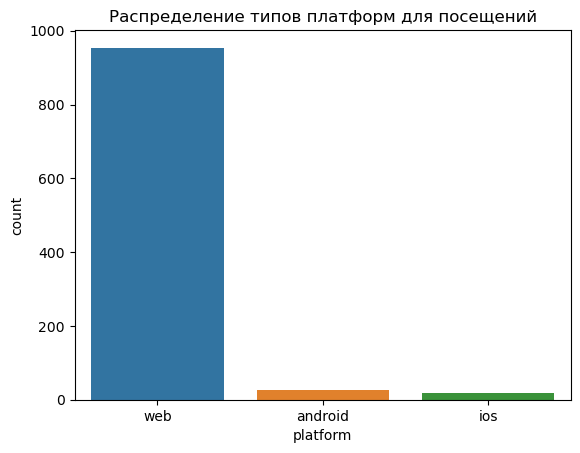

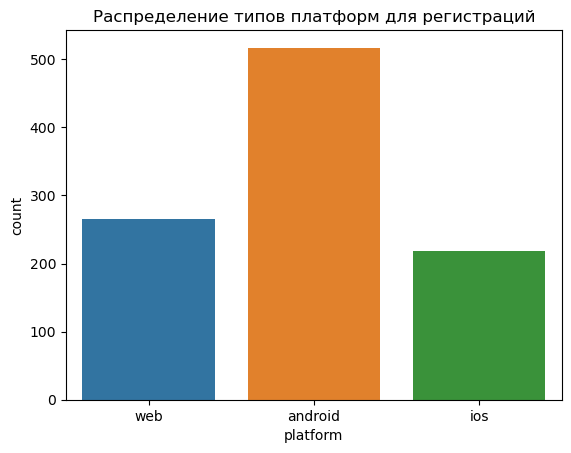

In [5]:
# Визуализация распределения типов платформ для посещений
sns.countplot(data=visits_df, x='platform')
plt.title('Распределение типов платформ для посещений')
plt.show()

# Визуализация распределения типов платформ для регистраций
sns.countplot(data=registrations_df, x='platform')
plt.title('Распределение типов платформ для регистраций')
plt.show()


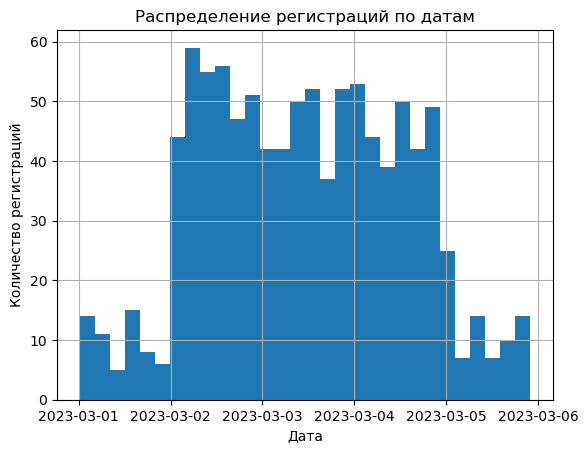

In [6]:
# Преобразуем дату регистрации в формат datetime
registrations_df['date'] = pd.to_datetime(registrations_df['date'])

# Построим график распределения регистраций по датам
registrations_df['date'].hist(bins=30)
plt.title('Распределение регистраций по датам')
plt.xlabel('Дата')
plt.ylabel('Количество регистраций')
plt.show()


In [7]:
# Объединение данных по 'user_id' и 'uuid'
merged_df = pd.merge(visits_df, registrations_df, left_on='uuid', right_on='user_id', how='inner')


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [8]:
# Преобразуем столбцы в строковый тип
visits_df['uuid'] = visits_df['uuid'].astype(str)
registrations_df['user_id'] = registrations_df['user_id'].astype(str)

# Теперь попробуем объединить данные
merged_df = pd.merge(visits_df, registrations_df, left_on='uuid', right_on='user_id', how='inner')


In [9]:
merged_df.head()


,uuid,platform_x,user_agent,date_x,date_y,user_id,email,platform_y,registration_type


In [19]:
import pandas as pd
import numpy as np
import requests

# --- Предполагается, что у вас уже есть загруженные visits_df и registrations_df ---

# 1. Удаление визитов ботов
visits_df_filtered = visits_df[~visits_df['user_agent'].str.lower().str.contains('bot')]

# 2. Выбор последнего визита для каждого visit_id
visits_latest = (
    visits_df_filtered.sort_values(by='datetime')
    .drop_duplicates(subset='visit_id', keep='last')
    .copy()
)

# 3. Добавление поля даты без времени
visits_latest.loc[:, 'date_group'] = visits_latest['datetime'].dt.date
registrations_df.loc[:, 'date_group'] = registrations_df['datetime'].dt.date

# 4. Группировка визитов по дате и платформе
visits_grouped = visits_latest.groupby(['date_group', 'platform']).size().reset_index(name='visits')

# 5. Группировка регистраций по дате и платформе
registrations_grouped = registrations_df.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

# 6. Объединение двух датафреймов
conversion_df = pd.merge(visits_grouped, registrations_grouped, how='outer', on=['date_group', 'platform'])

# 7. Замена NaN на 0 и преобразование в int
conversion_df[['visits', 'registrations']] = conversion_df[['visits', 'registrations']].fillna(0).astype(int)

# 8. Расчет конверсии
conversion_df['conversion'] = (conversion_df['registrations'] / conversion_df['visits'].replace(0, np.nan)) * 100
conversion_df['conversion'] = conversion_df['conversion'].fillna(0).round(2)

# 9. Сортировка по дате
conversion_df = conversion_df.sort_values(by='date_group')

# 10. Преобразование date_group в миллисекунды UNIX (для JSON-совместимости)
conversion_df['date_group'] = pd.to_datetime(conversion_df['date_group'])
conversion_df['date_group'] = conversion_df['date_group'].astype('int64') // 10**6  # UNIX timestamp in ms

# 11. Сохранение в JSON
conversion_df.to_json('conversion.json')


In [20]:
pip install gdown


Note: you may need to restart the kernel to use updated packages.


In [21]:
import gdown

url = 'https://drive.google.com/uc?id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj'
output = 'ads.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=12vCtGhJlcK_CBcs8ES3BfEPbk6OJ45Qj
To: C:\Users\Nadezhda\Documents\Хекслет Аналитика данных\Проект Дашборд конверсий v8\ads.csv
100%|██████████| 9.48k/9.48k [00:00<00:00, 119kB/s]


'ads.csv'

In [22]:
import pandas as pd

ads_df = pd.read_csv('ads.csv')

# Приводим столбец даты к формату без времени
ads_df['date_group'] = pd.to_datetime(ads_df['date']).dt.date


In [23]:
ads_grouped = ads_df.groupby('date_group').agg({
    'cost': 'sum',
    'utm_campaign': lambda x: ','.join(x.unique())  # можно выбрать первое значение или объединить
}).reset_index()


In [24]:
ads_grouped['date_group'] = pd.to_datetime(ads_grouped['date_group'])
ads_grouped['date_group'] = ads_grouped['date_group'].astype('int64') // 10**6  # UNIX timestamp (ms)


In [25]:
final_df = pd.merge(
    conversion_df,
    ads_grouped,
    how='left',
    on='date_group'
)

# Заполнение пропусков
final_df['cost'] = final_df['cost'].fillna(0).astype(int)
final_df['utm_campaign'] = final_df['utm_campaign'].fillna('none')

# Сортировка по дате
final_df = final_df.sort_values(by='date_group')


In [26]:
final_df.to_json('ads.json')


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Если дата хранится как миллисекунды
if pd.api.types.is_integer_dtype(final_df['date_group']):
    if final_df['date_group'].max() > 1e12:
        final_df['date_group'] = pd.to_datetime(final_df['date_group'], unit='ms')
    else:
        final_df['date_group'] = pd.to_datetime(final_df['date_group'], unit='s')


In [40]:
sns.set(style="whitegrid")
os.makedirs("./charts", exist_ok=True)


In [45]:
# 1. Итоговые визиты
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='visits')
plt.title('Total Visits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/total_visits.png')
plt.close()

# 2. Визиты по платформам
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='platform')
plt.title('Visits by Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/visits_by_platform.png')
plt.close()

# 3. Итоговые регистрации
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='registrations')
plt.title('Total Registrations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/total_registrations.png')
plt.close()

# 4. Регистрации по платформам
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='registrations', hue='platform')
plt.title('Registrations by Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/registrations_by_platform.png')
plt.close()

# 5. Конверсия по платформам
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='conversion', hue='platform')
plt.title('Conversion by Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/conversion_by_platform.png')
plt.close()

# 6. Средняя конверсия
avg_conversion = final_df.groupby('date_group')['conversion'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(data=avg_conversion, x='date_group', y='conversion')
plt.title('Average Conversion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/average_conversion.png')
plt.close()

# 7. Стоимости рекламы
if 'cost' in final_df.columns:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=final_df, x='date_group', y='cost')
    plt.title('Ad Costs')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./charts/ad_costs.png')
    plt.close()

# 8. Визиты с подсветкой рекламы
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='visits', hue='utm_campaign', palette='tab10')
plt.title('Visits by UTM Campaign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/visits_by_utm_campaign.png')
plt.close()

# 9. Регистрации с подсветкой рекламы
plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x='date_group', y='registrations', hue='utm_campaign', palette='tab10')
plt.title('Registrations by UTM Campaign')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./charts/registrations_by_utm_campaign.png')
plt.close()


In [46]:
from dotenv import load_dotenv
import os

# Загружаем переменные из файла .env
load_dotenv()

# Достаем значения переменных окружения
API_URL = os.getenv('API_URL')
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')

# Проверим, что переменные загружены
print(f'API_URL: {API_URL}')
print(f'DATE_BEGIN: {DATE_BEGIN}')
print(f'DATE_END: {DATE_END}')


API_URL: https://data-charts-api.hexlet.app
DATE_BEGIN: 2023-03-01
DATE_END: 2023-09-01
